In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tools.intersac_tools import plot_ressac
from navipy.tools import extract_block_nonans
from navipy.trajectories import Trajectory
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

%matplotlib inline

In [2]:
fname_results = 'chapter_3_results/classification_comparison.h5'

### Load results and plot

In [3]:
score_classifier_dtree = pd.read_hdf(fname_results,'/scores/dtree')
score_classifier_rforest = pd.read_hdf(fname_results,'/scores/rforest')
score_benchmark = pd.read_hdf(fname_results,'/scores/benchmark')

In [4]:
# Load list of flights
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')

# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

In [5]:
flightid = '17'
blk_i = 0
key = '/thresholds/flight_{}/blk_{}'.format(flightid,blk_i) 
thresholds = pd.read_hdf(head_filename_result_blocknonans,key=key)
thresholds_head = thresholds.loc['head']
thresholds_body = thresholds.loc['thorax']
# 1 - Load the data
# 1a - thorax
key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
body_velocity = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']
head_velocity = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
key = '/trajectories_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
body_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']
head_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
# 1b - Ground truth
key = '/res_sac/flight_{}/blk_{}'.format(flightid,blk_i) 
res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
res_sac_body = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']
key = '/blocksac/flight_{}/blk_{}'.format(flightid,blk_i) 
blocksac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
blocksac_body = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']

# Load classifier
clf_randomforest = joblib.load('chapter_3_results/best_randomforest.pkl')
clf_decisiontree = joblib.load('chapter_3_results/best_decisiontree.pkl')


In [6]:
def prepare_input_classifier(body_velocity, n):
    # 3b - observations
    observation = body_velocity.zyx.dalpha_2.copy() # angular vel around z axis
    list_of_values = []
    a = observation.rolling(n, center=True).apply(lambda x: list_of_values.append(x.values) or 0, raw=False)
    observations = pd.DataFrame(list_of_values, index=a.dropna().index, columns=np.arange(n)-n//2)
    # Lets check that we did not do a mess
    # the observations at time shift 0, should match the observation at the same index
    assert np.all(observations.loc[:,0] == observation.loc[observations.index]), \
        "Problem with building observations"
    return observations

# For the random forest
res_sac_head_preds = dict()
ws = pd.read_hdf(fname_results, '/best/rforest').window_size.astype(int)
observations = prepare_input_classifier(body_velocity,ws)
res_sac_head_pred = clf_randomforest.predict(observations)
res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
res_sac_head_preds['rforest'] = res_sac_head_pred.copy()
res_sac_head_pred[res_sac_head_pred==True] = np.nan
blocksac_pred_rforest = extract_block_nonans(res_sac_head_pred)

# For the random forest
ws = pd.read_hdf(fname_results, '/best/dtree').window_size.astype(int)
observations = prepare_input_classifier(body_velocity,ws)
res_sac_head_pred = clf_decisiontree.predict(observations)
res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
res_sac_head_preds['dtree'] = res_sac_head_pred.copy()
res_sac_head_pred[res_sac_head_pred==True] = np.nan
blocksac_pred_dtree = extract_block_nonans(res_sac_head_pred)

<ipython-input-7-5f4702c4a4ac>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{}'.format(f/fps) for f in ax1.get_xticks()])


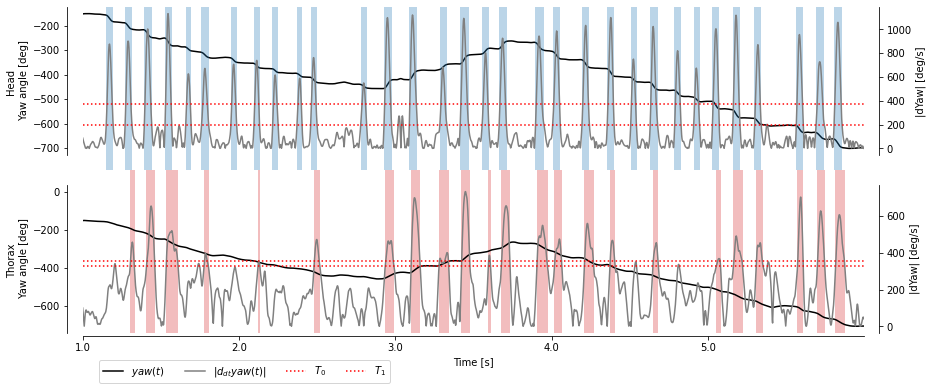

In [7]:
fps = 500
idx = np.arange(500,3000)
fig,axarr = plt.subplots(2,1,sharex=True,figsize=(14,6))
res_sac_head['filtered'] = head_traj.zyx.alpha_0
res_sac_head['first_deriv'] = head_velocity.zyx.dalpha_2
ax1,ax2=plot_ressac(axarr[0],res_sac_head.astype(float),blocksac_head,idx, thresholds_head, facecolor='C0')
ax1.set_ylabel('Head \n Yaw angle [deg]')
for ax in [ax1, ax2]:
    ax.spines['top'].set_color(None)
    ax.spines['bottom'].set_color(None)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_color(None)
ax2.spines['right'].set_position(('axes', +1.02))
ax1.spines['right'].set_color(None)
ax1.xaxis.set_ticks_position('none')

res_sac_body['filtered'] = body_traj.zyx.alpha_0
res_sac_body['first_deriv'] = body_velocity.zyx.dalpha_2
ax1,ax2=plot_ressac(axarr[1],res_sac_body.astype(float),blocksac_body,idx, thresholds_body, facecolor='C3')
ax1.set_ylabel('Thorax \n Yaw angle [deg]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(min(idx),max(idx))
for ax in [ax1, ax2]:
    ax.spines['top'].set_color(None)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_color(None)
ax2.spines['left'].set_color(None)
ax2.spines['right'].set_position(('axes', +1.02))
ax1.spines['right'].set_color(None)
ax1.set_xticklabels(['{}'.format(f/fps) for f in ax1.get_xticks()])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
#ax2.legend(ncol=3)
ax1.legend(handles=h1, labels=l1, ncol=4, loc=0, bbox_to_anchor=(0.40, -0.15))
ax1.set_facecolor((0,0,0,0))

import matplotlib.transforms as mtransforms
trans1 = mtransforms.blended_transform_factory(
    ax1.transData, ax1.transAxes)
for iii, (color, ys, blocksac) in enumerate(zip(['C0','C3'],
                                         [(2.2,1.1),(1.1,0)],
                                         [blocksac_head, blocksac_body])):
    for i, row in blocksac.loc[:,['start_th2','end_th2']].drop_duplicates().iterrows():
        if (row.start_th2 < min(idx)) or (row.start_th2 > max(idx)):
            continue
        ax1.fill_between([row.start_th2, row.end_th2], min(ys), max(ys), facecolor=color,
                         alpha=0.3, transform=trans1, linewidth=0, clip_on=False, edgecolor=None)   

fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_example_v1.svg')
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_example_v1.png')

<ipython-input-8-3f9b6b0ede88>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{}'.format(f/fps) for f in ax1.get_xticks()])


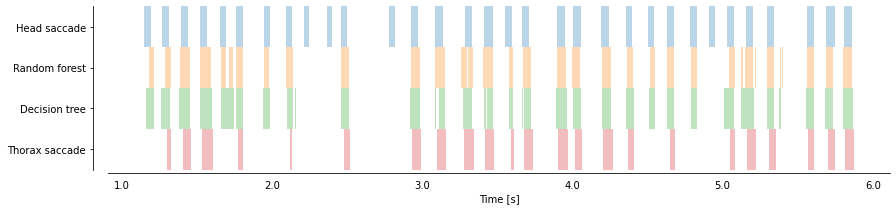

In [8]:
fig,ax1 = plt.subplots(1,1,sharex=True,figsize=(14,3))
import matplotlib.transforms as mtransforms
trans1 = mtransforms.blended_transform_factory(
    ax1.transData, ax1.transAxes)

#ys = (2.20,0*0.75)
#for i, row in blocksac_head.iterrows():
#    if (row.start_th2 < min(idx)) or (row.start_th2 > max(idx)):
#        continue
#    ax1.fill_between([row.start_th2, row.end_th2], min(ys), max(ys), facecolor=(0,0,0,0),
#                      transform=trans1, linewidth=1, clip_on=False, edgecolor='k', linestyle='--')    
for iii, (ys, blocksac) in enumerate(zip([(1.0,0.75),(0.75,0.5),(0.5,0.25),(0.25,0)],
                                         [blocksac_head, blocksac_pred_rforest, 
                                          blocksac_pred_dtree, blocksac_body])):
    for i, row in blocksac.loc[:,['start_th2','end_th2']].drop_duplicates().iterrows():
        if (row.start_th2 < min(idx)) or (row.start_th2 > max(idx)):
            continue
        ax1.fill_between([row.start_th2, row.end_th2], min(ys), max(ys), facecolor='C{}'.format(iii),
                         alpha=0.3, transform=trans1, linewidth=0, clip_on=False, edgecolor=None)    
ax1.set_ylim([0,1])
ax1.set_yticks(np.linspace(0.125,1-0.125,4))
ax1.set_yticklabels(['Thorax saccade', 'Decision tree', 'Random forest' ,'Head saccade', ])
ax1.spines['top'].set_color(None)
ax1.spines['right'].set_color(None)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax1.xaxis.set_ticks_position('none')
ax1.set_xticklabels(['{}'.format(f/fps) for f in ax1.get_xticks()])
ax1.set_xlabel('Time [s]')

fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_example_v2.svg')
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_example_v2.png')

## Ploting decision tree

The code below has been written to create a figure illustrating a decision tree.

In [9]:
ws = pd.read_hdf(fname_results, '/best/dtree').window_size.astype(int)

estimator = clf_decisiontree


def build_nxtree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    G = nx.DiGraph()
    for node_i, (feat, thres) in enumerate(zip(feature, threshold)):
         G.add_node(node_i, feature=feat, threshold=thres)
    # Connect left and right
    for node_i in range(n_nodes):
        node_j = children_left[node_i]
        if node_j>=0:
            G.add_edge(node_i,node_j, side='left')
        node_j = children_right[node_i]
        if node_j>=0:
            G.add_edge(node_i,node_j, side='right')
    return G

def assign_gpos(G):
    node_i = 0
    assert len(list(G.predecessors(node_i))) == 0 # Root node is not connected
    G.nodes[node_i]['pos'] = (0,0)
    G.nodes[node_i]['region'] = [-np.pi,np.pi]
    level=1
    def assign_child_pos(G, node_i,level):
        splits = np.linspace(G.nodes[node_i]['region'][0],
                             G.nodes[node_i]['region'][1],
                             len(G.edges(node_i))+1)
        splits = [splits[:-1],splits[1:]]
        for split_i,(_, node_j) in enumerate(G.edges(node_i)):
            G.nodes[node_j]['pos'] = (np.mean(splits[split_i]),70*level)
            G.nodes[node_j]['region'] = splits[split_i]    
            G=assign_child_pos(G, node_j,level+1)
        return G
    G = assign_child_pos(G, node_i,level)
    return G
        
def add_input(G, features):
    x = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[0,:]
    y = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[1,:]
    y = np.min(y)-np.diff(np.unique(y))[0]
    xs = np.linspace(x.min(),x.max(),len(features))
    for node_i in range(ws):
        G.add_node('f{}'.format(node_i),pos=(xs[node_i],y))
    for node_i, feat in nx.get_node_attributes(G,'feature').items():
        if feat>0:
            node_j = 'f{}'.format(feat)
            G.add_edge(node_j,node_i)
    return G

def draw_graph(ax,G):
    nx.draw_networkx_nodes(G,nx.get_node_attributes(G,'pos'),nodelist=range(estimator.tree_.node_count), node_size=20, 
                       alpha=0.5, node_color="blue")
    nx.draw_networkx_nodes(G,nx.get_node_attributes(G,'pos'),nodelist=['f{}'.format(node_i) for node_i in range(ws)], node_size=20, 
                           alpha=0.5, node_color="gray")
    edgelist=[]
    for edge in list(G.edges):
        if isinstance(edge[0],str):
            continue
        edgelist.append(edge)
    nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=edgelist,
                           width=1.0, edge_color='blue', style='solid', alpha=0.5)
    edgelist=[]
    edgelist1=[]
    for edge in list(G.edges):
        if isinstance(edge[0],int):
            continue
        if G.nodes[edge[0]]['pos'][0]>G.nodes[edge[1]]['pos'][0]:
            edgelist.append(edge)
        else:
            edgelist1.append(edge)
    nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=edgelist,
                           width=0.5, edge_color='gray', style='dotted', alpha=0.5,
                           connectionstyle='arc3, rad=0.1')
    nx.draw_networkx_edges(G,nx.get_node_attributes(G,'pos'), edgelist=edgelist1,
                           width=0.5, edge_color='gray', style='dotted', alpha=0.5,
                           connectionstyle='arc3, rad=-0.1')

    ax.text(-1.2*np.pi, -340,'Thorax angular z-velocity')
    ax.text(-1.2*np.pi, -70,'Input classifier')
    ax.text(-1.2*np.pi, 250,'Decision Tree')
    ax.invert_yaxis()
    ax.axis('off')
    # Annotate input nodes
    x = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[0,:]
    xs = np.linspace(min(x),max(x),ws)
    for x_i, cxs in enumerate(xs):
        if np.mod(x_i,3):
            continue
        ax.text(cxs,-90,'t={}'.format(x_i-ws//2),horizontalalignment='center')

    
#def plot_bodyvel(ax, body_velocity):
    
G = build_nxtree(estimator)
G = assign_gpos(G)
G = add_input(G, np.arange(ws))

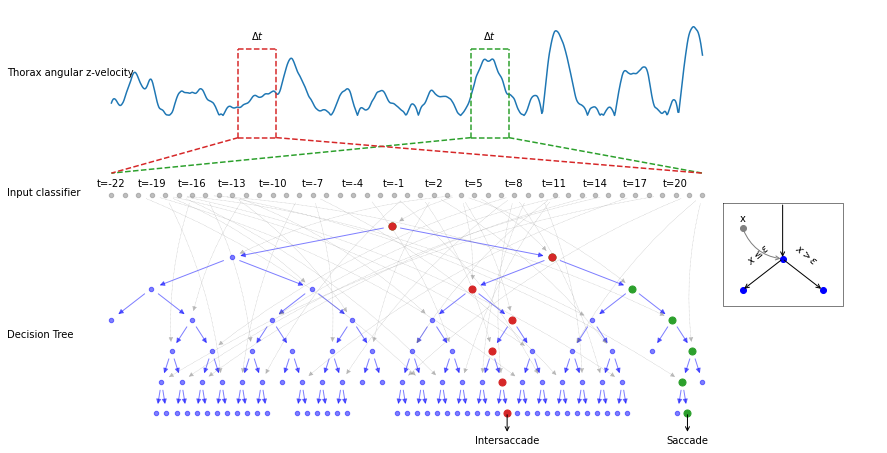

In [10]:
idx = np.arange(700,1400)

inputs = body_velocity.zyx.dalpha_2.abs().iloc[idx]

fig = plt.figure(figsize=(15, 8))
ax = fig.gca()
draw_graph(ax,G)
# plot
toplot = body_velocity.zyx.dalpha_2.abs().iloc[idx]
toplot -=np.min(toplot)
toplot /=np.max(toplot)
toplot*=-200
toplot+=-250
x = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[0,:]
xs = np.linspace(min(x),max(x),toplot.shape[0])
ax.plot(xs,toplot)

for offset, color in zip([425, 150], ['C2','C3']):
    X_test = inputs.values[offset:(offset+ws)].reshape(1, -1)
    # Get path
    node_indicator = estimator.decision_path(X_test)
    pred = estimator.predict(X_test)[0]
    # Similarly, we can also have the leaves ids reached by each sample.
    leave_id = estimator.apply(X_test)
    sample_id = 0
    node_path = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]
    nx.draw_networkx_nodes(G,nx.get_node_attributes(G,'pos'),nodelist=node_path.tolist(), node_size=50, 
                           alpha=1.0, node_color=color)
    # Plot
    ax.plot([xs[offset],xs[offset+ws]],[-200,-200],'--',color=color)
    ax.plot([xs[offset],xs[offset+ws]],[-400,-400],'--',color=color)
    ax.plot(2*[xs[offset]],[-200,-400],'--',color=color)
    ax.plot(2*[xs[offset+ws]],[-200,-400],'--',color=color)
    ax.plot([xs[offset],min(xs)],[-200,-120],'--',color=color)
    ax.plot([xs[offset+ws],max(xs)],[-200,-120],'--',color=color)
    ax.text(np.mean([xs[offset+ws],xs[offset]]),-420,'$\Delta t$',horizontalalignment='center')

    y = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[1,:]
    y1 = np.max(y)+1*np.diff(np.unique(y))[0]
    y2 = np.max(y)
    ax.annotate('Intersaccade' if pred else 'Saccade', 
            xy = (G.nodes[node_path[-1]]['pos'][0], y2),
            xytext = (G.nodes[node_path[-1]]['pos'][0], y1),
            arrowprops=dict(facecolor='black', arrowstyle='<-'),
            horizontalalignment='center')

# Add Explanation
x = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[0,:]
y = pd.DataFrame(nx.get_node_attributes(G,'pos')).loc[1,:]
dy = np.diff(np.unique(y))[0]
ax.plot([np.max(x)+3*np.pi/8],[np.mean(y)-dy],'bo')
ax.plot([np.max(x)+1*np.pi/8],[np.mean(y)-dy],'bo')
ax.plot([np.max(x)+np.pi/4],[np.mean(y)-2*dy],'bo')
ax.plot([np.max(x)+1.0*np.pi/8],[np.mean(y)-3*dy],'o',color='gray')
ax.annotate('',xy = (np.max(x)+np.pi/4, np.mean(y)-2*dy),
        xytext = (np.max(x)+1*np.pi/8, np.mean(y)-dy),
        arrowprops=dict(facecolor='blue', arrowstyle='<-'))
ax.annotate('',xy = (np.max(x)+np.pi/4, np.mean(y)-2*dy),
        xytext = (np.max(x)+3*np.pi/8, np.mean(y)-dy),
        arrowprops=dict(facecolor='blue', arrowstyle='<-'))
ax.annotate('',xy = (np.max(x)+np.pi/4, np.mean(y)-2*dy),
        xytext = (np.max(x)+2*np.pi/8, np.mean(y)-3.8*dy),
        arrowprops=dict(facecolor='blue', arrowstyle='->'))
ax.annotate('',xy = (np.max(x)+np.pi/4, np.mean(y)-2*dy),
        xytext = (np.max(x)+1.0*np.pi/8, np.mean(y)-3*dy),
        arrowprops=dict(facecolor='gray', edgecolor='gray', arrowstyle='->',
                        connectionstyle="arc3,rad=0.3"))
ax.text(np.max(x)+np.pi/8,np.mean(y)-3.2*dy,'x',horizontalalignment='center')
ax.text(np.max(x)+1.4*np.pi/8,np.mean(y)-1.8*dy,'$x\leq \epsilon $',
        horizontalalignment='center', rotation=40)
ax.text(np.max(x)+2.6*np.pi/8,np.mean(y)-1.8*dy,'$x> \epsilon $',
        horizontalalignment='center', rotation=-40)
ax.plot([np.max(x)+0.5*np.pi/8, np.max(x)+3.5*np.pi/8, np.max(x)+3.5*np.pi/8, np.max(x)+0.5*np.pi/8,np.max(x)+0.5*np.pi/8 ],
        [np.mean(y)-3.8*dy, np.mean(y)-3.8*dy, np.mean(y)-0.5*dy, np.mean(y)-0.5*dy, np.mean(y)-3.8*dy],'k-',linewidth=0.5)
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_DecisionTreePlot.svg')
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_DecisionTreePlot.png')

## Classification error

The accuracy is the fraction of correctly classified samples. Thus, the error rate is 1-accuracy

In [11]:
def confusion_matrix_extended(y_true, y_pred):
    """ Derive info from confusion matrix
    
    see https://en.wikipedia.org/wiki/Confusion_matrix
    """
    extended_confmat = dict()
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    extended_confmat['True positive'] = tp
    extended_confmat['True negative'] = tn
    extended_confmat['False positive'] = fp
    extended_confmat['False negative'] = fn
    # Condition positive/negative
    extended_confmat['Condition positive'] = np.sum(y_true==True)
    extended_confmat['Condition negative'] = np.sum(y_true==False)
    # Predicted positive/negative
    extended_confmat['Predicted positive'] = np.sum(y_pred==True)
    extended_confmat['Predicted negative'] = np.sum(y_pred==False)
    # Other quantity
    extended_confmat['Total population'] = y_pred.shape[0]
    extended_confmat['Prevalence'] = extended_confmat['Condition positive'] \
                                   / extended_confmat['Total population']
    extended_confmat['ACC'] = (tp+tn) \
                                   / extended_confmat['Total population']
    # Value normalised by predicted condition
    extended_confmat['PPV'] = tp / extended_confmat['Predicted positive']
    extended_confmat['FOR'] = fn / extended_confmat['Predicted negative']
    extended_confmat['FDR'] = fp / extended_confmat['Predicted positive']
    extended_confmat['NPV'] = tn / extended_confmat['Predicted negative']
    # Value normalised by condition
    extended_confmat['TPR'] = tp / extended_confmat['Condition positive']
    extended_confmat['FNR'] = fn / extended_confmat['Condition positive']
    extended_confmat['FPR'] = fp / extended_confmat['Condition negative']
    extended_confmat['TNR'] = tn / extended_confmat['Condition negative']
    # Likelihood ratio
    extended_confmat['LR+'] = extended_confmat['TPR'] / extended_confmat['FPR']
    extended_confmat['LR-'] = extended_confmat['FNR'] / extended_confmat['TNR']
    # Diagnostic odd radio and F1 score
    extended_confmat['DOR'] = extended_confmat['LR+']/extended_confmat['LR-']
    extended_confmat['F1score'] = 2*(extended_confmat['PPV']*extended_confmat['TPR']) \
                                / (extended_confmat['PPV']+extended_confmat['TPR'])
    from sklearn.metrics import roc_auc_score
    extended_confmat['AUC'] = roc_auc_score(y_true, y_pred)
    return pd.Series(extended_confmat)

In [12]:
score = confusion_matrix_extended(np.array([1,1,0,1]), 
                                  np.array([0,1,0,1])) # Just to get an index
scores = pd.DataFrame(columns = ['dtree','rforest','benchmark'],
                      index=score.index)
for model  in ['dtree','rforest']:
    y_pred = res_sac_head_preds[model]
    y_true = res_sac_head.loc[y_pred.index].saccade.isna()
    score = confusion_matrix_extended(y_true, y_pred)
    y_pred = res_sac_body.loc[y_pred.index].saccade.isna()
    benchmark = confusion_matrix_extended(y_true, y_pred)
    error_benchmark = 1-benchmark['ACC']
    error_clf = 1-score['ACC']
    msg = 'The model {} yeld an error rate of {:02.2f}%. In contrast the "traditional" trehsholding an error rate of {:02.2f}%.'
    msg += '\nThus the model yeld {:02.2f}% less miss-classification than the "traditional" method.'
    print(msg.format(model,100*error_clf,100*error_benchmark,100-100*error_clf/error_benchmark))
    scores.loc[:,model] = score.copy()
    scores.loc[:,'benchmark'] = benchmark.copy()

The model dtree yeld an error rate of 11.91%. In contrast the "traditional" trehsholding an error rate of 18.70%.
Thus the model yeld 36.29% less miss-classification than the "traditional" method.
The model rforest yeld an error rate of 11.26%. In contrast the "traditional" trehsholding an error rate of 18.68%.
Thus the model yeld 39.72% less miss-classification than the "traditional" method.


<ipython-input-11-e1542613a33a>:36: RuntimeWarning: divide by zero encountered in double_scalars
  extended_confmat['LR+'] = extended_confmat['TPR'] / extended_confmat['FPR']


In [13]:
scores

dtree      rforest    benchmark
True positive       2226.000000  2274.000000  2214.000000
True negative        799.000000   775.000000   580.000000
False positive       206.000000   230.000000   425.000000
False negative       203.000000   157.000000   217.000000
Condition positive  2429.000000  2431.000000  2431.000000
Condition negative  1005.000000  1005.000000  1005.000000
Predicted positive  2432.000000  2504.000000  2639.000000
Predicted negative  1002.000000   932.000000   797.000000
Total population    3434.000000  3436.000000  3436.000000
Prevalence             0.707338     0.707509     0.707509
ACC                    0.880897     0.887369     0.813155
PPV                    0.915296     0.908147     0.838954
FOR                    0.202595     0.168455     0.272271
FDR                    0.084704     0.091853     0.161046
NPV                    0.797405     0.831545     0.727729
TPR                    0.916427     0.935418     0.910736
FNR                    0.083573     0.064582     0.089264
FPR                    0.204975     0.228856     0.422886
TNR                    0.795025     0.771144     0.577114
LR+                    4.470916     4.087368     2.153624
LR-                    0.105121     0.083749     0.154672
DOR                   42.531302    48.805040    13.923773
F1score                0.915861     0.921581     0.873373
AUC                    0.855726     0.853281     0.743925

## Robustness

### How robust is it to 2D recordings?

Many recordings of animal are done from a single perspective or without having at least three identifiable points on the thorax. Such constrain lead to approximation in the animal orientation. Indeed to obtain the orientation of a body in space we need at least three non-colinear points. To retrieve part of the orientation with less visible point, assumption need to be made. Common assumptions when estimating the animal yaw orientation, is to say that animals have a null roll and pitch. For our recording, this assumption would lead to marker positions not having the same altitude at all time. 

In [14]:
# as in chap_02_OrientationAndErrorPropaagation
marker_filename_template = 'Marker/flight_{}/marker_traj.csv'
markers_body = ['0', '1', '2']
triangle_mode = 'y-axis=2-1'
rotconv = 'zyx'
cfilename = marker_filename_template.format(flightid)
markers_traj=pd.read_csv(cfilename,header=[0,1],index_col=0)
# set z to avg per frame 
markers_traj = markers_traj.loc[:, markers_body].swaplevel(axis=1)
zmean = markers_traj.z.mean(axis=1)
markers_traj.z = zmean
markers_traj = markers_traj.swaplevel(axis=1)
markers_traj.head()

0                                1                        \
             x          y          z          x          y          z   
336  17.505787 -63.362469  28.539654  13.745679 -63.083001  28.539654   
337  17.359374 -63.122502  28.698168  13.579907 -62.779239  28.698168   
338  17.376467 -62.814075  28.837764  13.510625 -62.454807  28.837764   
339  13.575265 -61.945427  26.084567   9.965785 -61.354147  26.084567   
340  13.520859 -61.516805  26.340977   9.902311 -60.996162  26.340977   

             2                        
             x          y          z  
336  16.416573 -60.028344  28.539654  
337  16.267226 -59.750442  28.698168  
338  16.327828 -59.568948  28.837764  
339  12.750731 -58.619845  26.084567  
340  12.699638 -58.325228  26.340977

In [15]:
# Calc trajectory body
body_trajzcst = Trajectory(rotconv=rotconv).from_markers(markers_traj, triangle_mode, 
                                                     markers_labels=markers_body)
body_trajzcst.head()

location                             zyx                
             x          y          z   alpha_0 alpha_1 alpha_2
336  15.889347 -62.157938  28.539654 -2.423121     0.0    -0.0
337  15.735502 -61.884061  28.698168 -2.415863     0.0    -0.0
338  15.738307 -61.612610  28.837764 -2.368232     0.0    -0.0
339  12.097260 -60.639806  26.084567 -2.347019     0.0    -0.0
340  12.040936 -60.279399  26.340977 -2.333085     0.0    -0.0

In [16]:
body_trajzcst.filt_cspline(lamb=pd.Series(index=body_trajzcst.columns,data=150))

/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


### How robust is it with downsamp?

The recording of flight orientation is not often done at 500fps. Notably, long lasting experiments (such as learning flight and search behaviour) are often recorded at a lower frame rate in order to be able to handle (store and process) the raw data. Here we ask the question whether are method can be applied to lower frame rate recording of yaw orientation. To answer this question, we downsampled our validation trajectory, interpolated then with a CubicSpline to recover the 500fps on which our classifier can work with.

Downsampling and reinterpolation example with cubic spline

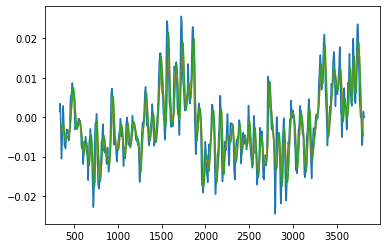

In [17]:
from scipy.interpolate import CubicSpline

def downsamp_interpolate(body_traj, downsamp):
    down_bdvel = Trajectory().from_dataframe(body_traj.iloc[::downsamp])
    down_bdvel = down_bdvel.velocity(frame='body')/downsamp # Devide by downsamp to make comparable to body_traj vel
    interpol_bdvel = pd.DataFrame(index=np.arange(down_bdvel.dropna().index[0],down_bdvel.dropna().index[-1]+1),
                                  columns = down_bdvel.columns)
    for col in interpol_bdvel.columns:
        x = down_bdvel.dropna().index
        y = down_bdvel.dropna().loc[:,col]
        cs = CubicSpline(x, y)
        interpol_bdvel.loc[:, col] = cs(interpol_bdvel.index)
    return interpol_bdvel, down_bdvel
    
downsamp = 21
key = '/trajectories_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
body_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']

interpol_bdvel, down_bdvel = downsamp_interpolate(body_traj, downsamp)

idx = np.arange(500,3000)
fig = plt.figure()
ax = fig.gca()
ax.plot(body_velocity.zyx.dalpha_2)
ax.plot(down_bdvel.zyx.dalpha_2,'C1')
ax.plot(interpol_bdvel.zyx.dalpha_2,'C2')

Test classifier performance with different fps

In [18]:
from scipy import signal
from navipy.tools import extract_block
high_pass = np.array([+1, 0, -1], np.float)

downsamps = np.arange(1,51,1)
scores = dict()
scores['rforest'] = dict()
scores['dtree'] = dict()
scores['threshold'] = dict()
scores['rforest2D'] = dict()
scores['dtree2D'] = dict()
benchmarks = dict()
benchmarks['rforest'] = dict()
benchmarks['dtree'] = dict()
benchmarks['threshold'] = dict()
benchmarks['rforest2D'] = dict()
benchmarks['dtree2D'] = dict()

for ds in downsamps:
    # Downsampling and interpolate
    interpol_bdvel, _ = downsamp_interpolate(body_traj, ds)
    interpol_bdvel2d, _ = downsamp_interpolate(body_trajzcst.loc[body_traj.index,:], ds)
    # Thresholding
    first_deriv = interpol_bdvel.zyx.dalpha_2
    blocksac = extract_block(np.abs(first_deriv), thresholds_body).astype(int)
    res_sac_head_pred = pd.Series(data=True, index=first_deriv.index)
    for ii, block in blocksac.iterrows():
        res_sac_head_pred.loc[block.start_th2:block.end_th2] = False
    res_sac_head_preds['threshold'] = res_sac_head_pred.copy()
    
    # Random forest
    ws = pd.read_hdf(fname_results, '/best/rforest').window_size.astype(int)
    observations = prepare_input_classifier(interpol_bdvel,ws)
    res_sac_head_pred = clf_randomforest.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['rforest'] = res_sac_head_pred.copy()
    # Decision Tree
    ws = pd.read_hdf(fname_results, '/best/dtree').window_size.astype(int)
    observations = prepare_input_classifier(interpol_bdvel,ws)
    res_sac_head_pred = clf_decisiontree.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['dtree'] = res_sac_head_pred.copy()
    
    # Random forest 2d
    ws = pd.read_hdf(fname_results, '/best/rforest').window_size.astype(int)
    observations = prepare_input_classifier(interpol_bdvel2d,ws)
    res_sac_head_pred = clf_randomforest.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['rforest2D'] = res_sac_head_pred.copy()
    
    # Decision Tree
    ws = pd.read_hdf(fname_results, '/best/dtree').window_size.astype(int)
    observations = prepare_input_classifier(interpol_bdvel2d,ws)
    res_sac_head_pred = clf_decisiontree.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['dtree2D'] = res_sac_head_pred.copy()
    
    for model  in ['dtree', 'rforest', 'threshold', 'rforest2D', 'dtree2D']:
        y_pred = res_sac_head_preds[model]
        y_true = res_sac_head.loc[y_pred.index].saccade.isna()
        scores[model][ds] = confusion_matrix_extended(y_true, y_pred)
        y_pred = res_sac_body.loc[y_pred.index].saccade.isna()
        benchmarks[model][ds] = confusion_matrix_extended(y_true, y_pred)

We assemble the results stored in a dictionary in a dataframe to ease the plotting process

In [19]:
scores_df = dict()
benchmarks_df = dict()
for model  in ['dtree', 'rforest', 'threshold', 'rforest2D', 'dtree2D']:
    scores_df[model] = pd.concat(scores[model])
    benchmarks_df[model] = pd.concat(benchmarks[model])
benchmarks_df = pd.concat(benchmarks_df).unstack()
scores_df = pd.concat(scores_df).unstack()
benchmarks_df.head()

True positive  True negative  False positive  False negative  \
dtree 1         2212.0          580.0           425.0           217.0   
      2         2211.0          580.0           425.0           217.0   
      3         2209.0          580.0           425.0           217.0   
      4         2207.0          580.0           425.0           217.0   
      5         2205.0          580.0           425.0           217.0   

         Condition positive  Condition negative  Predicted positive  \
dtree 1              2429.0              1005.0              2637.0   
      2              2428.0              1005.0              2636.0   
      3              2426.0              1005.0              2634.0   
      4              2424.0              1005.0              2632.0   
      5              2422.0              1005.0              2630.0   

         Predicted negative  Total population  Prevalence  ...       NPV  \
dtree 1               797.0            3434.0    0.707338  ...  0.727729   
      2               797.0            3433.0    0.707253  ...  0.727729   
      3               797.0            3431.0    0.707082  ...  0.727729   
      4               797.0            3429.0    0.706912  ...  0.727729   
      5               797.0            3427.0    0.706741  ...  0.727729   

              TPR       FNR       FPR       TNR       LR+       LR-  \
dtree 1  0.910663  0.089337  0.422886  0.577114  2.153450  0.154800   
      2  0.910626  0.089374  0.422886  0.577114  2.153363  0.154864   
      3  0.910552  0.089448  0.422886  0.577114  2.153188  0.154991   
      4  0.910479  0.089521  0.422886  0.577114  2.153014  0.155119   
      5  0.910405  0.089595  0.422886  0.577114  2.152839  0.155247   

               DOR   F1score       AUC  
dtree 1  13.911195  0.873273  0.743889  
      2  13.904906  0.873223  0.743870  
      3  13.892329  0.873123  0.743833  
      4  13.879751  0.873022  0.743796  
      5  13.867173  0.872922  0.743760  

[5 rows x 24 columns]

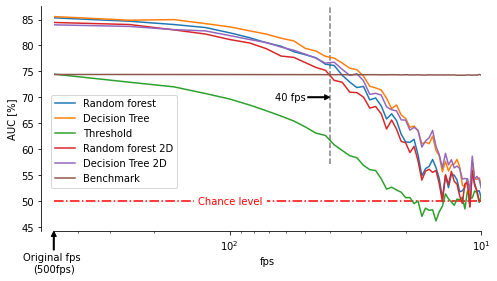

In [20]:
fps = 500
xaxis = fps/downsamps
quantity = 'AUC'
fig, axarr = plt.subplots(1,1, figsize=(7,4))
func = lambda x: x*100
ax = axarr
ax.semilogx(xaxis,func(pd.Series(scores_df.loc['rforest',quantity])), label='Random forest')
ax.semilogx(xaxis,func(pd.Series(scores_df.loc['dtree',quantity])), label='Decision Tree')
ax.semilogx(xaxis,func(pd.Series(scores_df.loc['threshold',quantity])), label='Threshold')
ax.semilogx(xaxis,func(pd.Series(scores_df.loc['rforest2D',quantity])), label='Random forest 2D')
ax.semilogx(xaxis,func(pd.Series(scores_df.loc['dtree2D',quantity])), label='Decision Tree 2D')
ax.semilogx(xaxis,func(pd.Series(benchmarks_df.loc['rforest',quantity])), label='Benchmark')
ax.invert_xaxis()
ax.set_xlabel('fps')
ax.set_xlim([max(xaxis),min(xaxis)])
#ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.03))
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
    
# chancelevel=100*res_sac_head.saccade.isna().mean() # For ACC
chancelevel = 50
ax.axvline(40, ymin=0.30, color='gray',linestyle='--', zorder=0)
#ax.axvline(500, ymin=0.30, color='gray',linestyle='--', zorder=0, clip_on=False)
ax.axhline(chancelevel,
           color='red',linestyle='-.',zorder=0)

ax.set_ylabel(quantity+' [%]')
ax.annotate('Original fps \n(500fps)', 
                  xy=(500, min(ax.get_ylim())), 
                  xytext=(500, 38),
                  arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center')
ax.annotate('40 fps', 
                  xy=(40, 70), 
                  xytext=(50, 70),
            arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='right',verticalalignment='center')

ax.text(100, chancelevel, 'Chance level', color='red', 
              horizontalalignment='center',verticalalignment='center', bbox=dict(facecolor='w',
                                                                                 edgecolor='w',
                                                                                 alpha=1.0))
#axarr[1].set_ylabel('Error [%]')
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.3, 0.63))
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_fps_dependence.svg')
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_fps_dependence.png')

We see that our classifiers perform better than our benchmark for frame rate above 40fps. 

## How robust is it to lambda in filtering



In [21]:
# Calc trajectory body
key = '/trajectories/flight_{}/blk_{}'.format(flightid,blk_i) 
body_traj = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']

In [32]:
from scipy import signal
from navipy.tools import extract_block
import tqdm
high_pass = np.array([+1, 0, -1], np.float)

lambdas = np.arange(50,250,10)
scores = dict()
scores['rforest'] = dict()
scores['dtree'] = dict()
scores['threshold'] = dict()
scores['rforest2D'] = dict()
scores['dtree2D'] = dict()
benchmarks = dict()
benchmarks['rforest'] = dict()
benchmarks['dtree'] = dict()
benchmarks['threshold'] = dict()
benchmarks['rforest2D'] = dict()
benchmarks['dtree2D'] = dict()

for lamb in tqdm.tqdm(lambdas):
    filtered = Trajectory().from_dataframe(body_traj.copy())
    filtered.filt_cspline(lamb=pd.Series(index=filtered.columns,data=lamb))
    # Downsampling and interpolate
    filtered_vel = filtered.velocity(frame='body')
    # Thresholding
    first_deriv = filtered_vel.zyx.dalpha_2
    blocksac = extract_block(np.abs(first_deriv), thresholds_body).astype(int)
    res_sac_head_pred = pd.Series(data=True, index=first_deriv.index)
    for ii, block in blocksac.iterrows():
        res_sac_head_pred.loc[block.start_th2:block.end_th2] = False
    res_sac_head_preds['threshold'] = res_sac_head_pred.copy()
    # Random forest
    ws = pd.read_hdf(fname_results, '/best/rforest').window_size.astype(int)
    observations = prepare_input_classifier(filtered_vel,ws)
    res_sac_head_pred = clf_randomforest.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['rforest'] = res_sac_head_pred.copy()
    # Decision Tree
    ws = pd.read_hdf(fname_results, '/best/dtree').window_size.astype(int)
    observations = prepare_input_classifier(filtered_vel,ws)
    res_sac_head_pred = clf_decisiontree.predict(observations)
    res_sac_head_pred = pd.Series(res_sac_head_pred,index=observations.index)
    res_sac_head_preds['dtree'] = res_sac_head_pred.copy()    
    for model  in ['dtree', 'rforest', 'threshold']:
        y_pred = res_sac_head_preds[model]
        # We reindex because we want to select the same
        # true value from res_sac_head from y_pred
        y_true = res_sac_head.reindex(y_pred.index).saccade.isna()
        scores[model][lamb] = confusion_matrix_extended(y_true, y_pred)
        y_pred = res_sac_body.reindex(y_pred.index).saccade.isna()
        benchmarks[model][lamb] = confusion_matrix_extended(y_true, y_pred)

  0%|          | 0/20 [00:00<?, ?it/s]/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np_traj = np.hstack([self.index[:, np.newaxis], np_traj])
  5%|▌         | 1/20 [00:05<01:43,  5.47s/it]/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np_traj = np.hstack([self.index[:, np.newaxis], np_traj])
 10%|█         | 2/20 [00:10<01:37,  5.44s/it]/home/bolirev/.virtualenvs/exp-2020/lib/python3.8/site-packages/navipy-0.1.2-py3.8.egg/navipy/trajectories/__init__.py:986: FutureWarning:

100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


We assemble the results stored in a dictionary in a dataframe to ease the plotting process

In [34]:
scores_df = dict()
benchmarks_df = dict()
for model  in ['dtree', 'rforest', 'threshold']:
    scores_df[model] = pd.concat(scores[model])
    benchmarks_df[model] = pd.concat(benchmarks[model])
benchmarks_df = pd.concat(benchmarks_df).unstack()
scores_df = pd.concat(scores_df).unstack()
benchmarks_df.head()

True positive  True negative  False positive  False negative  \
dtree 50         2212.0          580.0           425.0           217.0   
      60         2212.0          580.0           425.0           217.0   
      70         2212.0          580.0           425.0           217.0   
      80         2212.0          580.0           425.0           217.0   
      90         2212.0          580.0           425.0           217.0   

          Condition positive  Condition negative  Predicted positive  \
dtree 50              2429.0              1005.0              2637.0   
      60              2429.0              1005.0              2637.0   
      70              2429.0              1005.0              2637.0   
      80              2429.0              1005.0              2637.0   
      90              2429.0              1005.0              2637.0   

          Predicted negative  Total population  Prevalence  ...       NPV  \
dtree 50               797.0            3434.0    0.707338  ...  0.727729   
      60               797.0            3434.0    0.707338  ...  0.727729   
      70               797.0            3434.0    0.707338  ...  0.727729   
      80               797.0            3434.0    0.707338  ...  0.727729   
      90               797.0            3434.0    0.707338  ...  0.727729   

               TPR       FNR       FPR       TNR      LR+     LR-        DOR  \
dtree 50  0.910663  0.089337  0.422886  0.577114  2.15345  0.1548  13.911195   
      60  0.910663  0.089337  0.422886  0.577114  2.15345  0.1548  13.911195   
      70  0.910663  0.089337  0.422886  0.577114  2.15345  0.1548  13.911195   
      80  0.910663  0.089337  0.422886  0.577114  2.15345  0.1548  13.911195   
      90  0.910663  0.089337  0.422886  0.577114  2.15345  0.1548  13.911195   

           F1score       AUC  
dtree 50  0.873273  0.743889  
      60  0.873273  0.743889  
      70  0.873273  0.743889  
      80  0.873273  0.743889  
      90  0.873273  0.743889  

[5 rows x 24 columns]

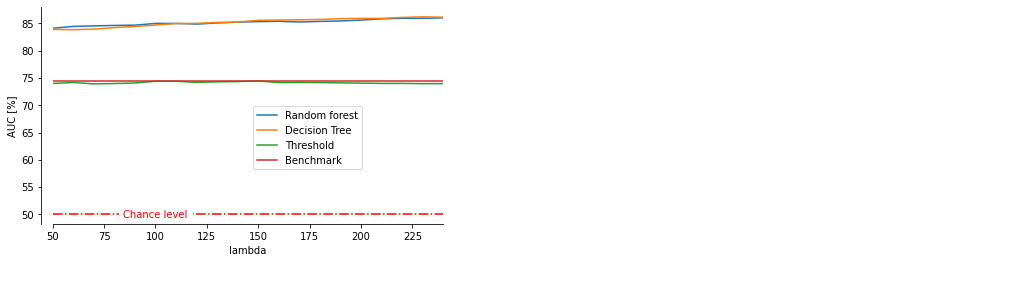

In [42]:
xaxis = lambdas
quantity = 'AUC'
fig= plt.figure(figsize=(7,4))
func = lambda x: x*100
ax = fig.gca()
ax.plot(xaxis,func(pd.Series(scores_df.loc['rforest',quantity])), label='Random forest')
ax.plot(xaxis,func(pd.Series(scores_df.loc['dtree',quantity])), label='Decision Tree')
ax.plot(xaxis,func(pd.Series(scores_df.loc['threshold',quantity])), label='Threshold')
ax.plot(xaxis,func(pd.Series(benchmarks_df.loc['rforest',quantity])), label='Benchmark')
ax.set_xlabel('lambda')
ax.set_xlim([min(xaxis),max(xaxis)])
#ax.spines['bottom'].set_position(('axes', -0.05))
ax.spines['left'].set_position(('axes', -0.03))
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
    
# chancelevel=100*res_sac_head.saccade.isna().mean() # For ACC
chancelevel = 50
ax.axvline(40, ymin=0.30, color='gray',linestyle='--', zorder=0)
#ax.axvline(500, ymin=0.30, color='gray',linestyle='--', zorder=0, clip_on=False)
ax.axhline(chancelevel,
           color='red',linestyle='-.',zorder=0)

ax.set_ylabel(quantity+' [%]')
ax.annotate('Original fps \n(500fps)', 
                  xy=(500, min(ax.get_ylim())), 
                  xytext=(500, 38),
                  arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center')
ax.annotate('40 fps', 
                  xy=(40, 70), 
                  xytext=(50, 70),
            arrowprops=dict(facecolor='black', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='right',verticalalignment='center')

ax.text(100, chancelevel, 'Chance level', color='red', 
              horizontalalignment='center',verticalalignment='center', bbox=dict(facecolor='w',
                                                                                 edgecolor='w',
                                                                                 alpha=1.0))
plt.legend(bbox_to_anchor=(0.5, 0.23))
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_lambda_dependence.svg')
fig.savefig('chapter_3_results/chap_03c_SaccadeIntersaccades_lambda_dependence.png')

## Classification accuracy of the hyperparameters

In [ ]:
vmin = 100*min([score_classifier_dtree.values.min(),
            score_classifier_rforest.values.min()])
vmax = 100*max([score_classifier_dtree.values.max(),
            score_classifier_rforest.values.max()])

fig, axarr = plt.subplots(1,2, sharey=True, figsize=(10,10))
ax = axarr[0]
toplot = 100*score_classifier_dtree.astype(float)
ax.imshow(toplot, vmin=vmin, vmax=vmax, 
          extent=[min(toplot.columns), max(toplot.columns),
                  max(toplot.index), min(toplot.index)])

maxidx = toplot.unstack().idxmax()
ax.plot([maxidx[0]],[maxidx[1]],'ro', linewidth=1, fillstyle='none')
ax.set_ylabel('Window size [frame]')
ax.set_xlabel('Number of leaves')
ax.set_title('Decision tree')
ax.annotate('Leaves={}'.format(maxidx[0]), 
                  xy=(maxidx[0], 51), 
                  xytext=(maxidx[0], 56),
                  arrowprops=dict(color='red', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center')
ax.annotate('WS={}'.format(maxidx[1]), 
                  xy=(20,maxidx[1]), 
                  xytext=(23,maxidx[1]),
                  arrowprops=dict(color='red', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center',rotation=90)

ax = axarr[1]
toplot = 100*score_classifier_rforest.astype(float)
im=ax.imshow(toplot, vmin=vmin, vmax=vmax, 
          extent=[min(toplot.columns), max(toplot.columns),
                  max(toplot.index), min(toplot.index)])
maxidx = toplot.unstack().idxmax()
#ax.plot([maxidx[0]-3,maxidx[0]+3],[maxidx[1],maxidx[1]],'r--', linewidth=0.5)
#ax.plot([maxidx[0],maxidx[0]],[maxidx[1]-3,maxidx[1]+3],'r--', linewidth=0.5)
ax.plot([maxidx[0]],[maxidx[1]],'ro', linewidth=1, fillstyle='none')
ax.set_xlabel('Number of leaves',bbox={'facecolor': 'w', 'alpha': 1.0, 'pad': 2, 'edgecolor':'w'})
ax.set_title('Random Forest')
ax.annotate('Leaves={}'.format(maxidx[0]), 
                  xy=(maxidx[0], 51), 
                  xytext=(maxidx[0], 56),
                  arrowprops=dict(color='red', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center',zorder=0)
ax.annotate('WS={}'.format(maxidx[1]), 
                  xy=(1,maxidx[1]), 
                  xytext=(-3,maxidx[1]),
                  arrowprops=dict(color='red', shrink=0.01, width=1, headwidth=5, headlength=5),
                  horizontalalignment='center',verticalalignment='center',rotation=90)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Accuracy [%]')

fig.savefig('chapter_3_results/chap_06c_SaccadeIntersaccades_hyperparameter.svg')
fig.savefig('chapter_3_results/chap_06c_SaccadeIntersaccades_hyperparameter.png')